In [2]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A

# In[2]:


import torch
torch.cuda.set_device(1)

In [4]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_train.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        head = "images, class\n"
        output_path_csv.write(head)

    
    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l)
#                     print(l)
                

In [5]:
create_csvValid("./dataset_split_38frames/train")

In [2]:
import pandas as pd
import numpy as np

dfValid = pd.read_csv('./dataset_split_38frames/df_train.csv')

dfTest = pd.read_csv('./dataset_split_38frames/df_test.csv')


# In[5]:


# prueba = dfValid


# prueba = prueba.iloc[np.random.permutation(len(prueba))]
# prueba = prueba[0:int(len(prueba)*0.1)]
# # In[6]:
# # Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# # usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# # dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]




# # Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# # 0.1 posiciones si está se devuelve 
# def is_valid(path):
#     name = path[0]
# #     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
#     return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# # In[13]:

# def get_class(path):
#     name = path[0]
#     return (dfValid[dfValid['images']==name])['class']


In [7]:
def get_dls(presize=50,size=38,M=0,bs=512):
    db = DataBlock(blocks = (ImageBlock, CategoryBlock),
             splitter=RandomSplitter(),
             get_x = ColReader(0,pref="./dataset_split_38frames/train/",suff='.jpg'),
             get_y=ColReader(1),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfValid.values,bs=bs)
    return dls

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnet_b2',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [9]:
dlsTrain3 = get_dls()


learn = Learner(dlsTrain3,timm.create_model('efficientnet_b2',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')],cbs=callbacks,
                loss_func= LabelSmoothingCrossEntropyFlat()).to_fp16()

NameError: name 'dfValid' is not defined

SuggestedLRs(valley=0.0008317637839354575)

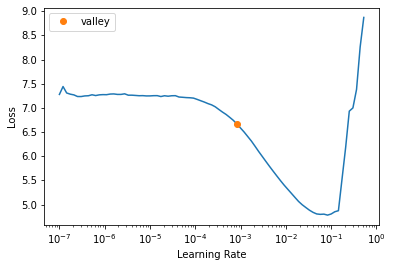

In [6]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,3.380788,4.358269,0.321643,0.392048,00:11


Better model found at epoch 0 with cohen_kappa_score value: 0.39204751151171335.


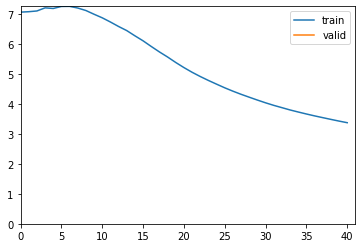

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.688434,1.736253,0.493998,0.668973,00:11
1,1.526212,1.457897,0.590773,0.734482,00:11
2,1.402736,1.389691,0.625469,0.774496,00:11
3,1.296891,1.304482,0.666729,0.788755,00:11
4,1.216490,1.234390,0.686234,0.810360,00:11
5,1.153435,1.205279,0.710990,0.821300,00:11
6,1.104656,1.201639,0.708740,0.834730,00:11
7,1.052825,1.252060,0.691860,0.793828,00:11
8,1.010603,1.115034,0.746999,0.842155,00:11
9,0.977921,1.123128,0.750375,0.845556,00:11


Better model found at epoch 0 with cohen_kappa_score value: 0.6689728326573682.


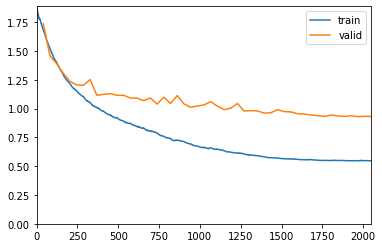

Better model found at epoch 1 with cohen_kappa_score value: 0.7344818910677186.
Better model found at epoch 2 with cohen_kappa_score value: 0.7744955310508168.
Better model found at epoch 3 with cohen_kappa_score value: 0.7887549561248057.
Better model found at epoch 4 with cohen_kappa_score value: 0.8103600759807973.
Better model found at epoch 5 with cohen_kappa_score value: 0.8212996610399335.
Better model found at epoch 6 with cohen_kappa_score value: 0.8347302911757783.
Better model found at epoch 8 with cohen_kappa_score value: 0.842155226942648.
Better model found at epoch 9 with cohen_kappa_score value: 0.8455557310302055.
Better model found at epoch 10 with cohen_kappa_score value: 0.8529582444471943.
Better model found at epoch 11 with cohen_kappa_score value: 0.8552641250235598.
Better model found at epoch 13 with cohen_kappa_score value: 0.8843564456386261.
Better model found at epoch 21 with cohen_kappa_score value: 0.8859612539272125.
Better model found at epoch 22 with c

In [7]:
learn.fine_tune(50,base_lr=3e-3)

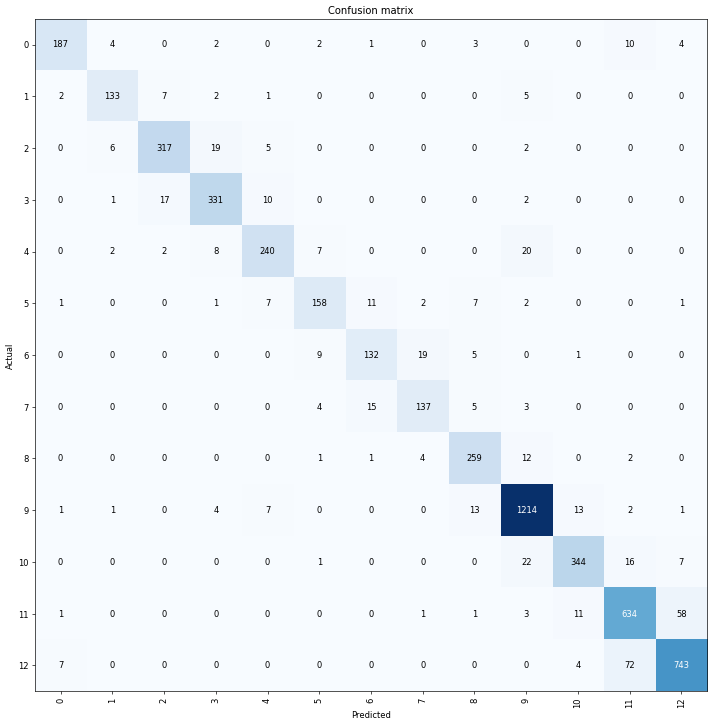

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [8]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x = ColReader(0,pref="./dataset_split_38frames/test/",suff='.jpg'),
                 get_y=ColReader(1),
                 item_tfms = Resize(100),
                 batch_tfms=[*aug_transforms(size=77, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTest.values,bs=128)



# dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),get_items=get_image_files, 
#                    splitter=GrandparentSplitter(valid_name='test'),get_y=parent_label, 
#                    item_tfms = Resize(512),batch_tfms=[*aug_transforms(size=256, min_scale=0.75), 
#                    Normalize.from_stats(*imagenet_stats)])
# dlsTest = dbTest.dataloaders("./dataset_split_77frames/df_test.csv",bs=32)

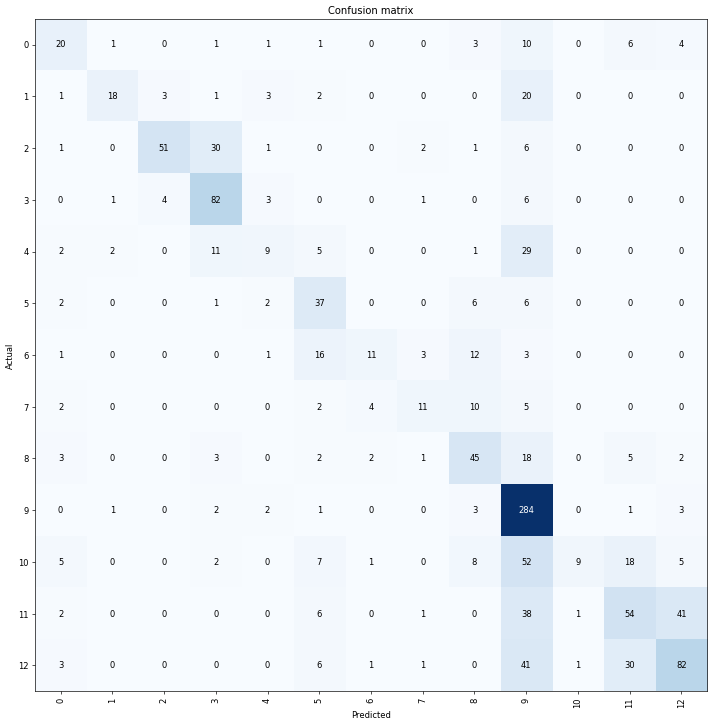

In [9]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [34]:
# learn.validate()

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


IndexError: list index out of range

In [35]:
# learn.export(fname='resnetrsRandAugLS_77frames.pkl')

PicklingError: Can't pickle typing.Callable[..., typing.Any]: it's not the same object as typing.Callable

In [6]:
learn1 = Learner(dlsTrain3,timm.create_model('efficientnet_b2',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')]).to_fp16()

NameError: name 'dlsTrain3' is not defined

In [12]:
learn1.load("efficientnet_b2")

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [13]:
learn1.export("efficientnet_b2_38frames.pkl")

In [10]:
learn1 = load_learner("./efficientnet_b2_38frames.pkl", 'efficientnet_b2_38frames.pkl')

In [11]:
learn1.validate()

(#3) [None,None,None]

In [14]:
preds,gt = learn1.tta()

TypeError: 'NoneType' object is not subscriptable

In [13]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
"""top_k_accuracy_score"""
accuracy_score(np.argmax(preds,axis=1),gt)

NameError: name 'preds' is not defined